In [10]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn import preprocessing
import os
import pathlib
import pandas as pd

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.image import resize

from tensorflow.keras import layers

In [11]:
train_path = pathlib.Path('datasets', 'train')
labels_path = pathlib.Path('datasets', 'labels.csv')

In [12]:
labels_df = pd.read_csv(labels_path)

In [13]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
le = preprocessing.LabelEncoder()
labels_df['target'] = le.fit_transform(labels_df['breed'].values)
labels_df.head()

,id,breed,target
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


In [15]:
def load_data(path, labels_df=None):
    data = []
    labels = []
    for file in os.listdir(path):
        img = load_img(pathlib.Path(path, file))
        img = np.array(img)
        data.append(img)
        if labels_df is not None:
            target = labels_df.loc[labels_df['id'].str.startswith(file.split('.')[0]), 'target'].values[0]
            labels.append(target)
    return data, labels

In [16]:
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray
from tqdm import tqdm

In [17]:
IMAGE_SIZE = (128, 128)

In [18]:
data, labels = load_data(train_path, labels_df)

In [19]:
def preprocess_input(data):
    for i in tqdm(range(len(data))):
        data[i] = resize(data[i], IMAGE_SIZE)
        #data[i] = rgb2gray(data[i])
        data[i] = 1./255. * data[i]
    return data

In [20]:
data = preprocess_input(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10222/10222 [02:53<00:00, 58.91it/s]


In [21]:
NUM_CLASSES = len(np.unique(labels_df['target'].values))

In [22]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import Model

In [23]:
base_model = Xception(weights= None, include_top=False, input_shape= (*IMAGE_SIZE,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = layers.Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
BATCH_SIZE=16

In [26]:
data = np.array(data)

In [27]:
type(data)

numpy.ndarray

In [28]:
data.shape

(10222, 128, 128, 3)

In [29]:
data = tf.convert_to_tensor(data)

In [30]:
data.shape

TensorShape([10222, 128, 128, 3])

In [31]:
len(np.unique(labels_df['target'].values))

120

In [32]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [33]:
labels_one_hot = indices_to_one_hot(labels, 120)

In [34]:
labels_one_hot.shape

(10222, 120)

In [35]:
import matplotlib.pyplot as plt

In [40]:
data[2].numpy().max()

0.003835784313725492

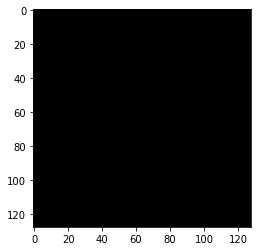

In [37]:
plt.imshow(data[16].numpy())

In [42]:
dataset = Dataset.from_tensor_slices((tf.cast(data, tf.float32), tf.cast(labels_one_hot, tf.float32))).shuffle(512)

ResourceExhaustedError: OOM when allocating tensor with shape[10222,128,128,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Cast]

In [53]:
DATASET_SIZE = len(dataset)

In [55]:
train_size = int(0.85 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)

In [57]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [58]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [68]:
from tensorflow.keras import metrics

m = metrics.sparse_top_k_categorical_accuracy(k=5)

TypeError: sparse_top_k_categorical_accuracy() missing 2 required positional arguments: 'y_true' and 'y_pred'

In [69]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.003), metrics=['accuracy'])

In [70]:
history = model.fit(train_dataset, validation_data=val_dataset,
                epochs=50,
                shuffle=True)
                #callbacks=[checkpoint])

Epoch 1/50
543/543 [==============================] - 83s 152ms/step - loss: 4.7782 - accuracy: 0.0124 - val_loss: 4.7848 - val_accuracy: 0.0111
Epoch 2/50
543/543 [==============================] - 83s 153ms/step - loss: 4.7779 - accuracy: 0.0127 - val_loss: 4.7906 - val_accuracy: 0.0085
Epoch 3/50
543/543 [==============================] - 81s 150ms/step - loss: 4.7780 - accuracy: 0.0129 - val_loss: 4.7880 - val_accuracy: 0.0098
Epoch 4/50
543/543 [==============================] - 79s 145ms/step - loss: 4.7785 - accuracy: 0.0123 - val_loss: 4.7903 - val_accuracy: 0.0104
Epoch 5/50
543/543 [==============================] - 82s 150ms/step - loss: 4.7783 - accuracy: 0.0123 - val_loss: 4.7850 - val_accuracy: 0.0098
Epoch 6/50
543/543 [==============================] - 81s 149ms/step - loss: 4.7786 - accuracy: 0.0123 - val_loss: 4.7851 - val_accuracy: 0.0130
Epoch 7/50
543/543 [==============================] - 80s 147ms/step - loss: 4.7781 - accuracy: 0.0122 - val_loss: 4.7870 - val_ac

KeyboardInterrupt: 